# 1. **Importing libraries that are planned to be used in our process**

In [34]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import xgboost
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
## for data
import pandas as pd

import re
import nltk## for language detection



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/supreme-court-judgment-prediction/justice.csv


# 2. Reading the dataset with pandas, dropping null values (calculated earlier at less than 5%) and creating a copy of the dataframe for the modelling process

In [4]:
df = pd.read_csv('../input/supreme-court-judgment-prediction/justice.csv', delimiter=',', encoding = "utf8")
df.dropna(inplace=True)
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [3]:
df1 = df.copy()

In [4]:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area', 
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

# 3. Seperating the dataset into target variables and two groups of independent variables, one (df_cat) which requires one-hot encoding to be machine readable and the other (df_nlp) which is text data which needs to be cleaned for features to be engineered from it.

In [5]:
df_cat = df1[['decision_type', 'disposition']]

In [6]:
df_target = df1['first_party_winner']

In [7]:
df_nlp = df1['facts']

# 4. Resetting indices to avoid NaNs during concatenation and performing one-hot encoding

In [8]:
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)

In [10]:
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [11]:
frames = [df_cat, df_target1]
df_concat = pd.concat(frames, axis=1, join='inner')
df_concat

,decision_type,disposition,first_party_winner
0,majority opinion,reversed/remanded,1
1,majority opinion,reversed/remanded,1
2,majority opinion,reversed/remanded,1
3,majority opinion,vacated/remanded,1
4,majority opinion,reversed,1
...,...,...,...
3093,majority opinion,reversed/remanded,1
3094,majority opinion,reversed/remanded,1
3095,majority opinion,affirmed,0
3096,majority opinion,vacated/remanded,1


In [12]:
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])

In [13]:
df_nlp1.head()

,facts
0,<p>Joan Stanley had three children with Peter ...
1,<p>John Giglio was convicted of passing forged...
2,"<p>The Idaho Probate Code specified that ""male..."
3,"<p>Miller, after conducting a mass mailing cam..."
4,<p>Ernest E. Mandel was a Belgian professional...


In [14]:
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


# 5. Performing initial cleaning and tokenizing the corpus, introducing a function to perform further cleaning and Lemmatization upon the data.

In [15]:
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [16]:
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [17]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [18]:

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [19]:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [20]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


# 6. Exploratory Data Analysis

In [21]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [22]:
df_nlp2["first_party_winner"].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

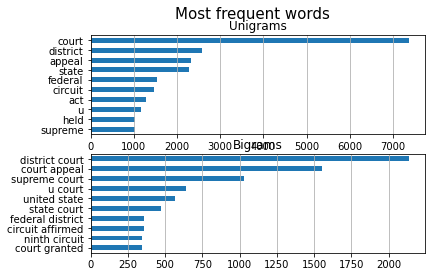

In [24]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

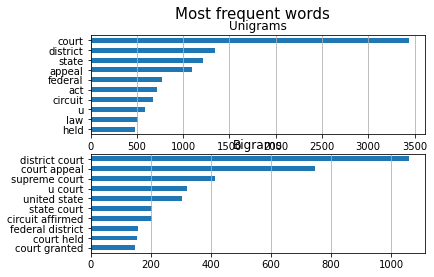

In [25]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [26]:
import wordcloud

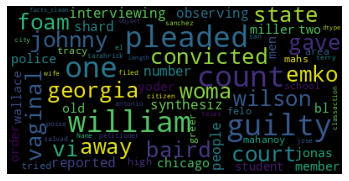

In [27]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [28]:
import gensim.downloader as gensim_api
import gensim
import seaborn as sns

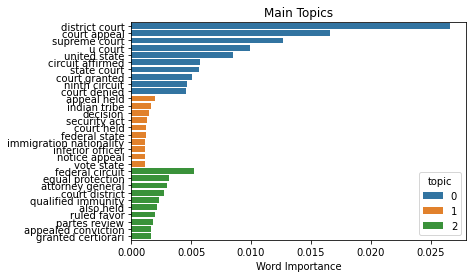

In [29]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

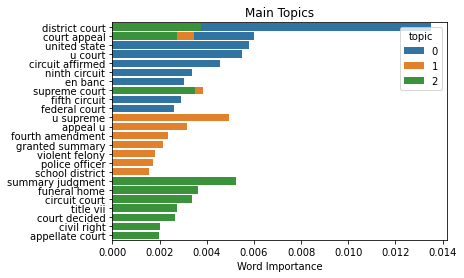

In [30]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

# 7. Introducing Count Vectorizer to derive features from textual data.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
vectorizer = CountVectorizer()

In [33]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [34]:
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

# 8. Using sklearn train_test_split and Pipeline to fit and score the model on Logistic Regression, RandomForest and K-NearestNeighbors on the newly engineered features

In [35]:
X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.25)

In [36]:
pipe = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])

In [37]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(solver='liblinear'))])

In [38]:
pipe.score(X_test,y_test)

0.632258064516129

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [40]:
pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])

In [41]:
pipe1.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [42]:
pipe1.score(X_train,y_train)

1.0

In [43]:
pipe1.score(X_test,y_test)

0.6761290322580645

In [44]:
pipe2= Pipeline(steps=[('cv',CountVectorizer()),('rf',KNeighborsClassifier(n_neighbors=3))])

In [45]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', KNeighborsClassifier(n_neighbors=3))])

In [46]:
pipe2.score(X_train,y_train)

0.7869134739560912

In [47]:
pipe2.score(X_test,y_test)

0.6141935483870967

# 9. Now including the one-hot encoded features within our model.

In [48]:
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')

In [49]:
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


In [50]:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [51]:
df_cat1 = pd.get_dummies(df_cat['decision_type'])

In [52]:
df_cat2 = pd.get_dummies(df_cat['disposition'])

In [53]:
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')

In [54]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion'],
      dtype='object')

In [55]:
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [56]:
vectorize=CountVectorizer()

In [57]:
count_matrix = vectorize.fit_transform(df_nl1['facts_clean'])
count_array = count_matrix.toarray()
data_final = pd.DataFrame(data=count_array,columns = vectorize.get_feature_names())

In [58]:
data_final = pd.concat([data_final,df_cat3],axis=1,join='inner')

In [59]:
data_final

,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3096,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [60]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'], 
                                                    test_size=0.3,random_state=10)

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

# 10. Performing LDA and hyper-parameter tuning

In [62]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda_data = lda.fit_transform(X_train)

In [63]:
lda_data_train = pd.DataFrame(data=lda_data)

In [64]:
lda_data_test = pd.DataFrame(data=lda.transform(X_test))

In [65]:
# Create the parameter grid based on the results of random search 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [8,10,12,14],
    'max_features': [60,70,80,90,100],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [66]:
grid_search.fit(lda_data_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min


[CV] max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=100, total=   3.9s
[CV] max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=200, total=   6.8s
[CV] max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=200, total=   7.0s
[CV] max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=300 
[CV]  max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=300, total=  11.1s
[CV] max_depth=8, max_features=60, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=8, max_features=60, min_samples_leaf=3, n_estimators=100, total=   3.4s
[CV] max_depth=8, max_features=60, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=8, max_features=60, min_samples_leaf=3, n_estimators=100, total=   3.3s
[CV] max_depth=8, max_features=60,

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.9min



[CV] max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=100, total=   6.4s
[CV] max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=100 
[CV]  max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=100, total=   5.5s
[CV] max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=200, total=  11.2s
[CV] max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=200 
[CV]  max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=200, total=  11.8s
[CV] max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=300 
[CV]  max_depth=8, max_features=100, min_samples_leaf=2, n_estimators=300, total=  17.0s
[CV] max_depth=8, max_features=100, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=8, max_features=100, min_samples_leaf=3, n_estimators=100, total=   5.9s
[CV] max_depth=8, max

[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 31.3min



[CV] max_depth=12, max_features=70, min_samples_leaf=2, n_estimators=300 
[CV]  max_depth=12, max_features=70, min_samples_leaf=2, n_estimators=300, total=  16.7s
[CV] max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=100, total=   5.3s
[CV] max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=100 
[CV]  max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=100, total=   6.1s
[CV] max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=200, total=  11.1s
[CV] max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=200 
[CV]  max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=200, total=  10.6s
[CV] max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=300 
[CV]  max_depth=12, max_features=70, min_samples_leaf=3, n_estimators=300, total=  16.5s
[CV] max_depth=12, ma

[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 52.6min finished


{'max_depth': 8,
 'max_features': 70,
 'min_samples_leaf': 4,
 'n_estimators': 200}

In [67]:
rand=RandomForestClassifier(max_depth= 8, max_features = 100, min_samples_leaf = 2, n_estimators = 200)

In [68]:
rand.fit(lda_data_train,y_train)

RandomForestClassifier(max_depth=8, max_features=100, min_samples_leaf=2,
                       n_estimators=200)

In [69]:
rand.score(lda_data_train,y_train)

0.702490774907749

In [70]:
rand.score(lda_data_test,y_test)

0.6709677419354839

In [71]:
from sklearn.metrics import f1_score

In [72]:
y_pred1 = rand.predict(lda_data_test)
f1_score(y_test, y_pred1)

0.8012987012987014

In [73]:
    model = XGBClassifier()
    model.fit(lda_data_train, y_train)
    y_pred = model.predict(lda_data_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    f1_score(y_test, y_pred1)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:01:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 65.05%


0.8012987012987014

In [74]:
knn=KNeighborsClassifier(n_neighbors=7)

In [75]:
knn.fit(lda_data_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [76]:
knn.score(lda_data_train,y_train)

0.7061808118081181

In [77]:
knn.score(lda_data_test,y_test)

0.6365591397849463

# 11. Deploying a LSTM Model to achieve higher accuracy

In [78]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [79]:
n_unique_words = 10000 # cut texts after this number of words
maxlen = 2000
batch_size = 32

In [80]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-10-12 08:01:53.833201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 08:01:53.834396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 08:01:53.835086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 08:01:53.835925: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [81]:
history=model.fit(lda_data_train, y_train,
           batch_size=batch_size,
           epochs=200,
           validation_data=[lda_data_test, y_test])

2022-10-12 08:01:58.799084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-10-12 08:02:01.569329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


68/68 [==============================] - 5s 16ms/step - loss: 0.6398 - accuracy: 0.6624 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/200
68/68 [==============================] - 1s 11ms/step - loss: 0.6388 - accuracy: 0.6670 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/200
68/68 [==============================] - 1s 11ms/step - loss: 0.6387 - accuracy: 0.6670 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/200
68/68 [==============================] - 1s 11ms/step - loss: 0.6376 - accuracy: 0.6670 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/200
68/68 [==============================] - 1s 11ms/step - loss: 0.6390 - accuracy: 0.6670 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/200
68/68 [==============================] - 1s 11ms/step - loss: 0.6383 - accuracy: 0.6670 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/200
68/68 [==============================] - 1s 11ms/step - loss: 0.6393 - accuracy: 0.6670 - val_loss: 

# **Thank you for taking the time to go through our submission. Any feedback is always welcome.**

In [19]:
df2 = df[['facts', 'disposition', 'decision_type', 'issue_area', 'first_party_winner']]

In [20]:
df2.head()

,facts,disposition,decision_type,issue_area,first_party_winner
1,<p>Joan Stanley had three children with Peter ...,reversed/remanded,majority opinion,Civil Rights,True
2,<p>John Giglio was convicted of passing forged...,reversed/remanded,majority opinion,Due Process,True
3,"<p>The Idaho Probate Code specified that ""male...",reversed/remanded,majority opinion,Civil Rights,True
4,"<p>Miller, after conducting a mass mailing cam...",vacated/remanded,majority opinion,First Amendment,True
5,<p>Ernest E. Mandel was a Belgian professional...,reversed,majority opinion,First Amendment,True


In [21]:
df2.isna().sum()

facts                 0
disposition           0
decision_type         0
issue_area            0
first_party_winner    0
dtype: int64

In [22]:
df2 = df2.dropna()

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3098 entries, 1 to 3302
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facts               3098 non-null   object
 1   disposition         3098 non-null   object
 2   decision_type       3098 non-null   object
 3   issue_area          3098 non-null   object
 4   first_party_winner  3098 non-null   object
dtypes: object(5)
memory usage: 145.2+ KB


In [24]:
#nltk.download('STOPWORDS')
stop_words = nltk.corpus.stopwords.words('english')

In [31]:
def remove_stopwords(row):
    sentence = row['facts']
    modified = []
    sentence = re.sub(r'<[a-z]+>', '', sentence)
    sentence = re.sub(r'\n', '', sentence)
    for p in string.punctuation:
        sentence = sentence.replace(p, '')
    for word in sentence.split():
        if word not in stop_words:
            modified.append(word)
    return ' '.join(modified).lower()

In [32]:
df2.head()

,facts,disposition,decision_type,issue_area,first_party_winner
1,<p>Joan Stanley had three children with Peter ...,reversed/remanded,majority opinion,Civil Rights,True
2,<p>John Giglio was convicted of passing forged...,reversed/remanded,majority opinion,Due Process,True
3,"<p>The Idaho Probate Code specified that ""male...",reversed/remanded,majority opinion,Civil Rights,True
4,"<p>Miller, after conducting a mass mailing cam...",vacated/remanded,majority opinion,First Amendment,True
5,<p>Ernest E. Mandel was a Belgian professional...,reversed,majority opinion,First Amendment,True


In [35]:
df2['facts_modified'] = df2.apply(remove_stopwords, axis = 1)

In [36]:
df2[[ 'facts', 'facts_modified']]

,facts,facts_modified
1,<p>Joan Stanley had three children with Peter ...,joan stanley three children peter stanley the ...
2,<p>John Giglio was convicted of passing forged...,john giglio convicted passing forged money ord...
3,"<p>The Idaho Probate Code specified that ""male...",the idaho probate code specified males must pr...
4,"<p>Miller, after conducting a mass mailing cam...",miller conducting mass mailing campaign advert...
5,<p>Ernest E. Mandel was a Belgian professional...,ernest e mandel belgian professional journalis...
...,...,...
3297,<p>For over a century after the Alaska Purchas...,for century alaska purchase 1867 federal gover...
3298,"<p>Refugio Palomar-Santiago, a Mexican nationa...",refugio palomarsantiago mexican national grant...
3299,<p>Tarahrick Terry pleaded guilty to one count...,tarahrick terry pleaded guilty one count posse...
3300,<p>Joshua James Cooley was parked in his picku...,joshua james cooley parked pickup truck side r...


In [37]:
print(df2['facts'].iloc[0])
print('----')
print(df2['facts_modified'].iloc[0])

<p>Joan Stanley had three children with Peter Stanley.  The Stanleys never married, but lived together off and on for 18 years.  When Joan died, the State of Illinois took the children.  Under Illinois law, unwed fathers were presumed unfit parents regardless of their actual fitness and their children became wards of the state.  Peter appealed the decision, arguing that the Illinois law violated the Equal Protection Clause of the Fourteenth Amendment because unwed mothers were not deprived of their children without a showing that they were actually unfit parents.  The Illinois Supreme Court rejected Stanley’s Equal Protection claim, holding that his actual fitness as a parent was irrelevant because he and the children’s mother were unmarried.</p>

----
joan stanley three children peter stanley the stanleys never married lived together 18 years when joan died state illinois took children under illinois law unwed fathers presumed unfit parents regardless actual fitness children became wa

In [38]:
df2

,facts,disposition,decision_type,issue_area,first_party_winner,facts_modified
1,<p>Joan Stanley had three children with Peter ...,reversed/remanded,majority opinion,Civil Rights,True,joan stanley three children peter stanley the ...
2,<p>John Giglio was convicted of passing forged...,reversed/remanded,majority opinion,Due Process,True,john giglio convicted passing forged money ord...
3,"<p>The Idaho Probate Code specified that ""male...",reversed/remanded,majority opinion,Civil Rights,True,the idaho probate code specified males must pr...
4,"<p>Miller, after conducting a mass mailing cam...",vacated/remanded,majority opinion,First Amendment,True,miller conducting mass mailing campaign advert...
5,<p>Ernest E. Mandel was a Belgian professional...,reversed,majority opinion,First Amendment,True,ernest e mandel belgian professional journalis...
...,...,...,...,...,...,...
3297,<p>For over a century after the Alaska Purchas...,reversed/remanded,majority opinion,Civil Rights,True,for century alaska purchase 1867 federal gover...
3298,"<p>Refugio Palomar-Santiago, a Mexican nationa...",reversed/remanded,majority opinion,Criminal Procedure,True,refugio palomarsantiago mexican national grant...
3299,<p>Tarahrick Terry pleaded guilty to one count...,affirmed,majority opinion,Criminal Procedure,False,tarahrick terry pleaded guilty one count posse...
3300,<p>Joshua James Cooley was parked in his picku...,vacated/remanded,majority opinion,Civil Rights,True,joshua james cooley parked pickup truck side r...


In [39]:
df2 = df2.drop(['facts'], axis = 1)

In [40]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
xgb = xgboost.XGBClassifier()
cbt = CatBoostClassifier()
svc = SVC()
models = [lr, dt, gb, rf, xgb, cbt, svc]
names = ['LogisticRegression', 'DecisionTreeClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'XGBClassifier','CatBoostClassifier', 'SVC']

In [41]:
def evaluate_models(X_train, y_train, X_val, y_val, feature = ""):
    xs = [X_train, y_train, X_val, y_val]
    random_seed = 0
    scores = []
    for i in range(len(models) - 1):
        model = models[i +1] 
        model.fit(X_train, y_train)
        y_predicted = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_predicted)
        f1score = f1_score(y_val, y_predicted)
        precision = precision_score(y_val, y_predicted)
        recall = recall_score(y_val, y_predicted)
        scores.append({
            'model':names[i] + ' with ' + feature ,
            'model_score':model.score(X_train, y_train),
            'accuracy' : accuracy,
            'f1_score' : f1score,
            'precision': precision,
            'recall' : recall
        })
    return pd.DataFrame(scores, columns=['model','model_score','accuracy','f1_score', 'precision', 'recall'])

In [42]:
def get_cv(X, y):
    scores = []
    for i in range(len(models)):
        model = models[i]
        cv = np.mean(np.absolute(cross_val_score(model, X, y, cv = 5)))
        scores.append({'model' : names[i],
                      'CV' : cv})
    return pd.DataFrame(scores, columns = ['model', 'CV'])

In [43]:
X = df2.reset_index().drop(['index','first_party_winner'], axis = 1)
y = df2.reset_index()['first_party_winner'].map({True:1, False:0})

In [44]:
for col in X.columns:
    if col != 'facts_modified':
        unique_val = {v : i for i,v in enumerate(np.unique(X[col]))}
        print(unique_val)
        X[col] = X[col].map(unique_val)

{'affirmed': 0, 'none': 1, 'reversed': 2, 'reversed in-part': 3, 'reversed in-part/remanded': 4, 'reversed/remanded': 5, 'vacated': 6, 'vacated in-part/remanded': 7, 'vacated/remanded': 8}
{'dismissal - improvidently granted': 0, 'dismissal - moot': 1, 'dismissal - other': 2, 'equally divided': 3, 'majority opinion': 4, 'opinion of the court': 5, 'per curiam': 6, 'plurality opinion': 7}
{'Attorneys': 0, 'Civil Rights': 1, 'Criminal Procedure': 2, 'Due Process': 3, 'Economic Activity': 4, 'Federal Taxation': 5, 'Federalism': 6, 'First Amendment': 7, 'Interstate Relations': 8, 'Judicial Power': 9, 'Miscellaneous': 10, 'Privacy': 11, 'Private Action': 12, 'Unions': 13}


In [45]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3)

****Using Bag of words approach

In [46]:
cv = CountVectorizer()

In [47]:
bowX = cv.fit_transform(X['facts_modified'])

In [48]:
df2.shape

(3098, 5)

In [49]:
bowX.toarray().shape

(3098, 25110)

In [50]:
bowX = pd.DataFrame(bowX.toarray())

In [51]:
bowX_df = pd.concat([bowX, X.drop(['facts_modified'], axis = 1)], axis = 1)

In [52]:
bowX_df

,0,1,2,3,4,5,6,7,8,9,...,25103,25104,25105,25106,25107,25108,25109,disposition,decision_type,issue_area
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,4,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,4,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,4,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,4,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,4,1
3094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,4,2
3095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
3096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,4,1


In [ ]:
get_cv(bowX_df, y)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

[13:07:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
bow_train = pd.DataFrame(cv.fit_transform(Xtrain['facts_modified']).toarray())
bow_train = pd.concat([bow_train, Xtrain.reset_index().drop(['index','facts_modified'], axis = 1)], axis = 1)

bow_test = pd.DataFrame(cv.transform(Xtest['facts_modified']).toarray())
bow_test = pd.concat([bow_test, Xtest.reset_index().drop(['index','facts_modified'], axis = 1)], axis = 1)

In [ ]:
bow_train

In [ ]:
bow_test

In [ ]:
evaluate_models(bow_train, ytrain, bow_test, ytest, feature = 'Bag of words')

In [ ]:
accuracy_score(ytest, models[4].predict(bow_test))

In [ ]:
import pickle as pk

In [ ]:
with open('bow_cv.pk', 'wb') as f:
  pk.dump(cv, f)

with open('model.pk', 'wb') as f:
  pk.dump(models[4], f)